# Assignment 4. Deep Learning

*Foundations of Data Science*  
*Dr. Khalaj (Fall 2023)*  

*For questions 1 refer to @alino_9 on Telegram. For questions 2-4 refer to @alregamo on Telegram.*

### Description  
This homework consists of four questions, each aimed at one category in the world of Deep Learning.   
1. Getting familiarized with sentiment analysis (A subject also covered in the course project).
   
2. Multi-layer perceptron (MLP).
   
3. Convolutional Neural Networks (CNN).
   
4. Variational Autoencoders (VAE).

### Information  
Complete the information box below.

In [ ]:
full_name = 'Hadi Hadavi'
student_id = '99100263'

### Note
The questions are not necessarily in order of difficulty. You are obligated to answer **3 out of 4** questions. The fourth question is optional and is considered as bonus.

## 4 Variation Autoencoder (VAE)

In this [link](https://lilianweng.github.io/posts/2018-08-12-vae/), you can find out more about autoencoders in general and a good explanation about variational autoencoders as well, known as VAEs.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

# Add Additional libraries here

torch.manual_seed(42)

The MNIST dataset is a large database of handwritten digits that is commonly used for training and testing various image processing and machine learning models. It contains 60,000 training images and 10,000 testing images of size (28, 28) and their corresponding labels from 0 to 9.

In [4]:
# Load the MNIST dataset
data = datasets.MNIST('data', train=True, download=True,
                      transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 174380864.13it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 111133664.06it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41211401.82it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5050511.34it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### 4.1 Data Visualization

Show 3 random samples from the dataset.

*Hint: you can use "cv2" library for reading images but any other method is acceptable.*

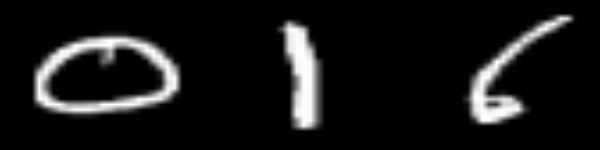

In [18]:
#################### Problem 01  ####################

# Extract images and labels from the dataset
images, labels = data.data, data.targets

# Get three random indices
random_indices = torch.randint(0, len(images), (3,))

# Concatenate the three images horizontally
horizontal_image = np.concatenate([images[idx].numpy() for idx in random_indices], axis=1)

# Resize the image array
resized_image = cv2.resize(horizontal_image, (600, 150))

# Use cv2_imshow to show the resized image in Colab
cv2_imshow(resized_image)

This code defines a VAE class for a variational autoencoder (VAE) model, a generative model with an encoder-decoder based structure. The encoder compresses an input to a latent vector, which is drawn from a distribution learned by the encoder outputs. The decoder reconstructs the input from the latent vector, and the model optimizes the reconstruction quality and the difference between the latent distribution and a prior distribution. A VAE class usually specifies the encoder and decoder networks, the sampling layer, and the loss function.

### 4.2 Complete the following class to define the VAE structure.

In [19]:
# Define the VAE architecture
class VAE(nn.Module):
    def __init__(self, hidden_size, latent_size):
        super(VAE, self).__init__()

        #################### Problem 02 - 03 ####################

        # Assign the dimensions of the hidden layer and the latent space
        self.hidden_dim = hidden_size
        self.latent_dim = latent_size

        # Define Encoder layers: map the input data to the mean and log variance of the latent space
        self.encoder_fc1 = nn.Linear(28 * 28, self.hidden_dim)
        self.encoder_fc2_mean = nn.Linear(self.hidden_dim, self.latent_dim)
        self.encoder_fc2_logvar = nn.Linear(self.hidden_dim, self.latent_dim)

        # Define Decoder layers: map the latent space to the reconstructed output data
        self.decoder_fc1 = nn.Linear(self.latent_dim, self.hidden_dim)
        self.decoder_fc2 = nn.Linear(self.hidden_dim, 28 * 28)

    def encode(self, x):
        #################### Problem 04  ####################
        '''
        Encode the input to the latent space using linear transformation layers and a ReLU activation function.
        '''

        x = F.relu(self.encoder_fc1(x))
        mean = self.encoder_fc2_mean(x)
        logvar = self.encoder_fc2_logvar(x)

        return mean, logvar

    def reparameterize(self, mu, logvar):
        #################### Problem 05  ####################
        '''
        # 1. Compute the standard deviation from the log variance
        # 2. Sample a random tensor from the standard normal distribution with the same shape as std
        # 3. Return a sample from the latent space using the reparameterization trick
        '''

        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std

        return z

    def decode(self, z):
        #################### Problem 06  ####################
        '''
        Decode the latent space to the output space through:
        1. Apply a linear transformation and a ReLU activation to the latent space
        2. Apply a linear transformation and a sigmoid activation to the hidden layer
        '''

        z = F.relu(self.decoder_fc1(z))
        x_reconstructed = torch.sigmoid(self.decoder_fc2(z))

        return x_reconstructed

    def forward(self, x):
        #################### Problem 07  ####################
        '''
        The forward propagation of your model:
        1. Encode the input data and get the mean and log variance of the latent space
        2. Reparameterize the mean and log variance and get a sample from the latent space
        3. Return the decoded samples, mu and logvar
        '''

        # Flatten the input image
        x = x.view(-1, 28 * 28)

        # Encode
        mu, logvar = self.encode(x)

        # Reparameterize
        z = self.reparameterize(mu, logvar)

        # Decode
        x_reconstructed = self.decode(z)

        return x_reconstructed, mu, logvar

### 4.3 Define the Loss Function
Compute the binary cross entropy between the reconstructed data and the original data.

Also, you need to compute the KL divergence between the distribution of the latent space and a standard normal distribution.

The total loss would be the sum of these two losses.

In [20]:
def loss_function(recon_x, x, mu, logvar):
    #################### Problem 08  ####################
    '''
    Compute the binary cross entropy between the reconstructed data and the original data
    Compute the KL divergence between the Gaussian distribution of the latent space and a standard normal distribution
    '''

    # Binary Cross Entropy Loss
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')

    # KL Divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD  # Return the sum of binary cross entropy and KL divergence as the total loss

### 4.4 Training the Model

Here we have provided a function which trains the model using the specified input arguments. (Make sure to understand the code!)

In [22]:
def train(model, optimizer, train_loader, epochs, device):
    model.train()
    train_loss = 0
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [24]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

#################### Problem 09  ####################
# Set the batch size for loading the data
batch_size = 64

#################### Problem 10  ####################
# Create a data loader object that shuffles and batches the data
train_dataset = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Choose the device (CPU or GPU) based on availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the VAE model and move it to the device
model = VAE(hidden_size=256, latent_size=20).to(device)

#################### Problem 11  ####################
# Create an instance of the Adam optimizer with a learning rate (try different learning rates)
# Set the number of epochs to train the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 10

# Train your VAE model
train(model, optimizer, train_loader, epochs, device)

====> Epoch: 9 Average loss: 1455.8782


### 4.5 Generative Model
Now that you have trained your model, you can generate new images by sampling from the latent space and decoding them as below: (make sure to understand how the code works!)

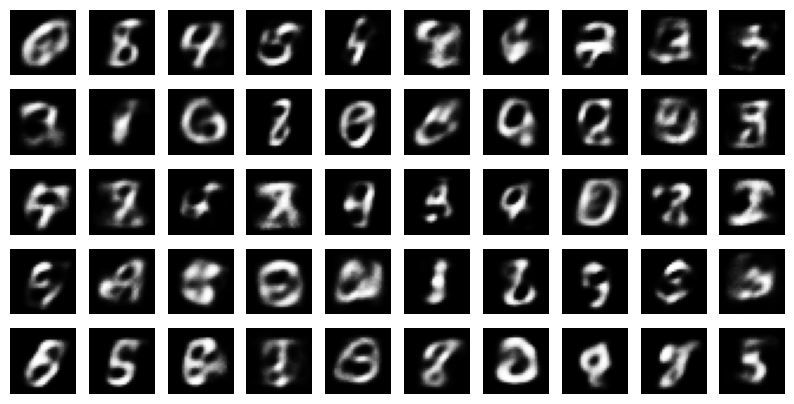

In [25]:
with torch.no_grad():
    z = torch.randn(batch_size, 20).to(device)
    sample = model.decode(z).cpu()

    # Plot the generated images
    fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(10,5))
    for i in range(5):
        for j in range(10):
            ax[i][j].imshow(sample[i*10+j].reshape(28, 28), cmap='gray')
            ax[i][j].axis('off')
    plt.show()